In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [61]:
solar_df   = pd.read_csv("Data_Cacak.csv",index_col='Datetime',parse_dates=True)
# solar_df = solar_df[~solar_df.index.duplicated(keep='first')]
# solar_df = solar_df.asfreq('h')
solar_df.head()

,AirTemperature,CloudOpacity,DHI,DNI,EBH,GHI,Production - Location 1,Production - Location 2,Production - Location 3
Datetime,,,,,,,,,
2022-11-22 14:00:00,8.7,59,117,0.0,0,117,11.705333,12.694917,16.355417
2022-11-22 15:00:00,8.9,62,62,0.0,0,62,1.309583,8.262333,1.812333
2022-11-22 16:00:00,9.2,57,15,7.0,1,16,0.000000,0.930667,0.000000
2022-11-22 17:00:00,8.9,81,0,0.0,0,0,0.000000,0.000000,0.000000
2022-11-22 18:00:00,8.9,91,0,0.0,0,0,0.000000,0.000000,0.000000


<Axes: xlabel='Datetime'>

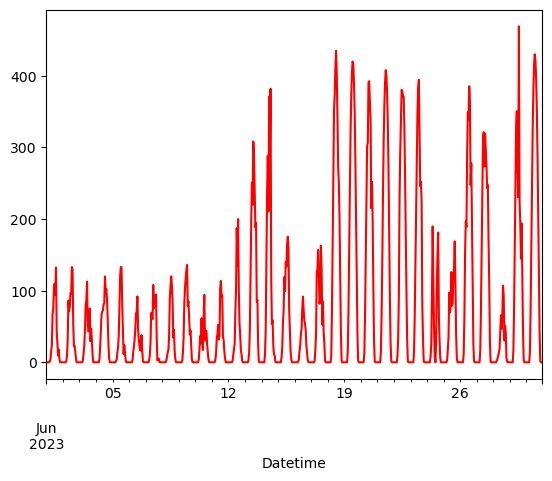

In [62]:
jun_2023_data = solar_df.loc['2023-6']
jun_2023_data['Production - Location 1'].plot(color='red')

<Axes: xlabel='Datetime'>

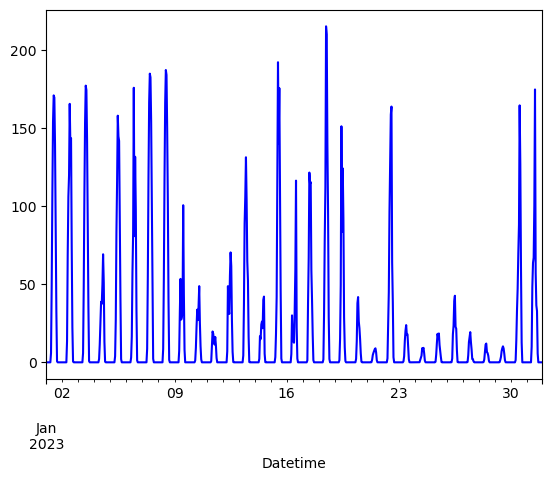

In [63]:
jan_2023_data = solar_df.loc['2023-1']
jan_2023_data['Production - Location 1'].plot(color='blue')

In [64]:
prev_time = solar_df.index[0]


for current_time in solar_df.index[1:]:
    expected_time = prev_time + pd.Timedelta(hours=1)
    
    if current_time != expected_time:
        print(f"Missing hour detected between {prev_time} and {current_time}")
        print(f"Expected {expected_time}, found {current_time}")
    
    prev_time = current_time

Missing hour detected between 2023-03-26 01:00:00 and 2023-03-26 03:00:00
Expected 2023-03-26 02:00:00, found 2023-03-26 03:00:00
Missing hour detected between 2023-10-29 02:00:00 and 2023-10-29 02:00:00
Expected 2023-10-29 03:00:00, found 2023-10-29 02:00:00


In [65]:
# 1. First ensure your index is datetime type
solar_df.index = pd.to_datetime(solar_df.index)

# 2. Localize to Serbia's timezone (Europe/Belgrade)
solar_df.index = solar_df.index.tz_localize('Europe/Belgrade', 
                                          ambiguous='infer',  # Handles duplicate 02:00 hour in fall
                                          nonexistent='shift_forward')  # Handles missing 02:00 in spring

# 3. Now convert to UTC
solar_df.index = solar_df.index.tz_convert('UTC')

# Verify the results
print(solar_df.loc['2023-03-26 00:00':'2023-03-26 03:00'].head())  # Spring transition
print(solar_df.loc['2023-10-29 00:00':'2023-10-29 03:00'].head())  # Fall transition

                           AirTemperature  CloudOpacity  DHI  DNI  EBH  GHI  \
Datetime                                                                      
2023-03-26 00:00:00+00:00             8.4             0    0  0.0    0    0   
2023-03-26 01:00:00+00:00             6.0             3    0  0.0    0    0   
2023-03-26 02:00:00+00:00             4.9             0    0  0.0    0    0   
2023-03-26 03:00:00+00:00             4.2             0    0  0.0    0    0   

                           Production - Location 1  Production - Location 2  \
Datetime                                                                      
2023-03-26 00:00:00+00:00                      0.0                      0.0   
2023-03-26 01:00:00+00:00                      0.0                      0.0   
2023-03-26 02:00:00+00:00                      0.0                      0.0   
2023-03-26 03:00:00+00:00                      0.0                      0.0   

                           Production - Location 3

#### check for messing data an other time

In [76]:
prev_time = solar_df.index[0]

# Iterate through the index to check continuity
for current_time in solar_df.index[1:]:
    expected_time = prev_time + pd.Timedelta(hours=1)
    
    if current_time != expected_time:
        print(f"Missing hour detected between {prev_time} and {current_time}")
        print(f"Expected {expected_time}, found {current_time}")
    
    prev_time = current_time

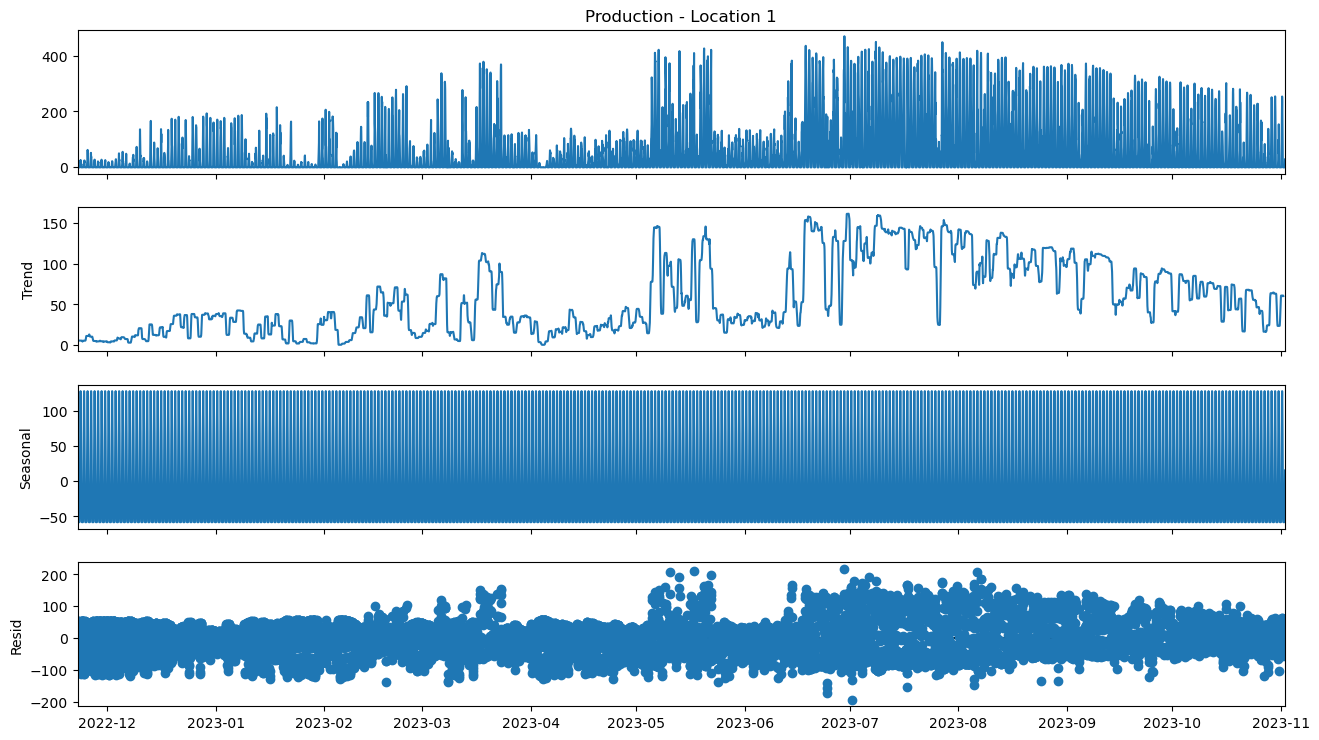

In [82]:
from statsmodels.tsa.seasonal import seasonal_decompose

# plt.close('all')
results = seasonal_decompose(solar_df['Production - Location 1'])
results.plot()
plt.gcf().set_size_inches(15, 8)  # gcf = "Get Current Figure"
# plt.tight_layout()
plt.show()

In [84]:
solar_df.size

74466

In [86]:
solar_df['time']=solar_df.index.hour
# solar_df['time']=solar_df['time'].apply(lambda x: x.timestamp())
X=solar_df[['time','AirTemperature',	'CloudOpacity',	'DHI',	'DNI','EBH','GHI']]
Y=solar_df['Production - Location 1']

test_size = 0.2
split_index = int(len(X) * (1 - test_size))


X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = Y[:split_index], Y[split_index:]

# To see the number of lines in each sample
print(f"Taille de X_train: {len(X_train)}, Taille de X_test: {len(X_test)}")
print(f"Taille de y_train: {len(y_train)}, Taille de y_test: {len(y_test)}")

Taille de X_train: 6619, Taille de X_test: 1655
Taille de y_train: 6619, Taille de y_test: 1655


# Applying RandomForestRegressor model without scaling data

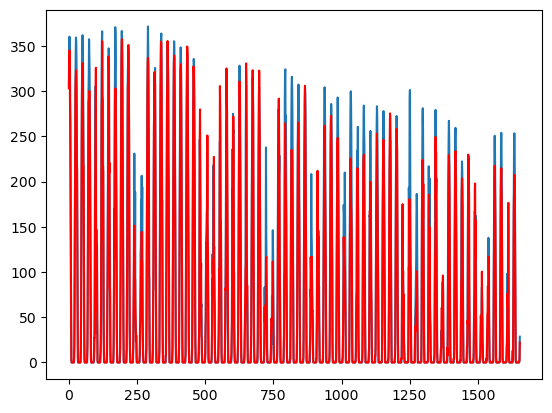

In [88]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100,max_depth=10 , random_state=42,min_samples_leaf=1, min_samples_split= 10)
#grid search is used to find these parameters


rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

y_test_l = list(y_test)
plt.plot(y_test_l, label='Actual')
plt.plot(y_pred, label='Predicted', color='red')
plt.show()

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE (Mean Absolute Error) : {mae:.4f}")
print(f"MSE (Mean Squared Error) : {mse:.4f}")
print(f"RMSE (Root Mean Squared Error) : {rmse:.4f}")
print(f"R² Score: {r2:.2f}")

MAE (Mean Absolute Error) : 13.2690
MSE (Mean Squared Error) : 686.1386
RMSE (Root Mean Squared Error) : 26.1942
R² Score: 0.94


# Normalize data before applying RFR

R² is the same because decision trees (and thus RandomForest) do not require feature scaling (unlike SVM, Neural Networks, or Gradient Boosting in some cases). 

They split based on feature thresholds, not distances, so scaling does not affect performance.

In [93]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()


X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1)).ravel()

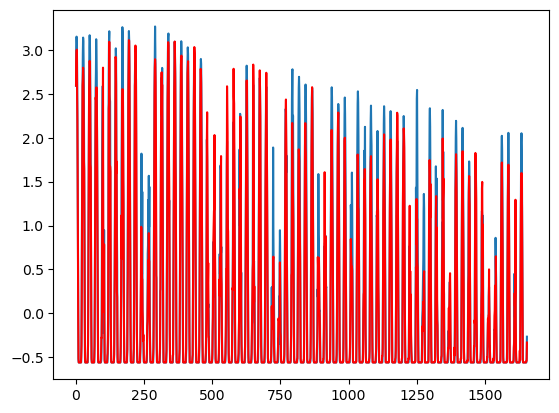

In [95]:
#grid search is used to find these parameters
rf_regressor = RandomForestRegressor(n_estimators=100,max_depth=10 , random_state=42,min_samples_leaf=1, min_samples_split= 10)



rf_regressor.fit(X_train_scaled, y_train_scaled)

y_pred = rf_regressor.predict(X_test_scaled)
y_test_l = list(y_test_scaled)
plt.plot(y_test_l, label='Actual')
plt.plot(y_pred, label='Predicted', color='red')
plt.show()

In [97]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

mae = mean_absolute_error(y_test_scaled, y_pred)
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled , y_pred)

print(f"MAE (Mean Absolute Error) : {mae:.4f}")
print(f"MSE (Mean Squared Error) : {mse:.4f}")
print(f"RMSE (Root Mean Squared Error) : {rmse:.4f}")
print(f"R² Score: {r2:.2f}")

MAE (Mean Absolute Error) : 0.1364
MSE (Mean Squared Error) : 0.0728
RMSE (Root Mean Squared Error) : 0.2699
R² Score: 0.94
